In [7]:
import numpy as np
import cv2
import pandas as pd
import os
import argparse
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [1]:
def load_video_frames_from_directory(n_videos, directory, img_height, img_width, batch_size, start_frame=50, frame_gap=5):
    video_paths_positive = [os.path.join(directory, 'Accident', f) for f in os.listdir(os.path.join(directory, 'Accident')) if f.endswith('.mp4')]
    video_paths_negative = [os.path.join(directory, 'NonAccident', f) for f in os.listdir(os.path.join(directory, 'NonAccident')) if f.endswith('.mp4')]
    frames_list = []
    labels_list = []

    # Function to determine whether to include a frame based on the frame counter
    def include_frame(frame_counter):
        return (frame_counter >= start_frame) and ((frame_counter - start_frame) % frame_gap == 0)

    # Load videos with positive label
    positive_count = 0
    for video_path in video_paths_positive:
        if positive_count >= n_videos:
            break
        cap = cv2.VideoCapture(video_path)
        frame_counter = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if include_frame(frame_counter):
                frame = cv2.resize(frame, (img_width, img_height))
                frames_list.append(frame)
                labels_list.append(1)  # Positive label
            frame_counter += 1
        cap.release()
        positive_count += 1

    # Load videos with negative label
    negative_count = 0
    for video_path in video_paths_negative:
        if negative_count >= n_videos:
            break
        cap = cv2.VideoCapture(video_path)
        frame_counter = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            if include_frame(frame_counter):
                frame = cv2.resize(frame, (img_width, img_height))
                frames_list.append(frame)
                labels_list.append(0)  # Negative label
            frame_counter += 1
        cap.release()
        negative_count += 1
    
    frames_array = np.array(frames_list)
    labels_array = np.array(labels_list)

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Apply data augmentation to frames
    augmented_frames = []
    for frame in frames_array:
        augmented_frame = datagen.random_transform(frame)
        augmented_frames.append(augmented_frame)

    augmented_frames_array = np.array(augmented_frames)

    dataset = tf.data.Dataset.from_tensor_slices((augmented_frames_array, labels_array))
    dataset = dataset.shuffle(len(frames_array)).batch(batch_size)
    return dataset

In [10]:
# Example usage:
directory = r'C:\Users\User\Desktop\Ajay\Video Data\train'
img_height, img_width = 224, 224
batch_size = 32
training_ds = load_video_frames_from_directory(10,directory, img_height, img_width, batch_size)
directory = r'C:\Users\User\Desktop\Ajay\Video Data\test'
validation_ds = load_video_frames_from_directory(10,directory, img_height, img_width, batch_size)

In [11]:
# Define the input shape based on the dataset element_spec
input_shape = (224, 224, 3)

# Define the model with adjusted dropout rate and additional data augmentation
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Increased L2 regularization
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Increased L2 regularization
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Increased L2 regularization
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.6))  # Adjusted dropout rate
    model.add(layers.Dense(64, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Increased L2 regularization
    model.add(layers.Dense(1))  # Output layer, assuming binary classification
    return model

# Create the model
cnn_model = create_cnn_model(input_shape)

# Compile the model with Adam optimizer and lower learning rate
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Define a learning rate scheduler with adjusted parameters
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0.00001)

# # Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Print model summary
cnn_model.summary()


C:\Users\User\anaconda3\envs\nilesh2\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,132,673 (42.47 MB)

 Trainable params: 11,132,353 (42.47 MB)

 Non-trainable params: 320 (1.25 KB)

In [12]:
# Define the number of epochs


# Train the model with early stopping and learning rate scheduler
history = cnn_model.fit(training_ds, epochs=20, validation_data=validation_ds, callbacks=[lr_scheduler, early_stopping])


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 820ms/step - accuracy: 0.5937 - loss: 1.1718 - val_accuracy: 0.4850 - val_loss: 21.9804 - learning_rate: 1.0000e-04
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - accuracy: 0.9672 - loss: 0.3398 - val_accuracy: 0.4850 - val_loss: 16.9029 - learning_rate: 1.0000e-04
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 797ms/step - accuracy: 0.9715 - loss: 0.3112 - val_accuracy: 0.4850 - val_loss: 17.1089 - learning_rate: 1.0000e-04
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 808ms/step - accuracy: 0.9894 - loss: 0.2526 - val_accuracy: 0.4850 - val_loss: 13.7205 - learning_rate: 1.0000e-04
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 799ms/step - accuracy: 1.0000 - loss: 0.2487 - val_accuracy: 0.4900 - val_loss: 12.6765 - learning_rate: 1.0000e-04
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 797ms/step - accuracy: 1.0000 - loss: 0.2451 - val_accuracy: 0.4850 - val_loss: 10.3743 - learning_rate: 1.0000e-04
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 810ms/step - accuracy: 1.0000 -

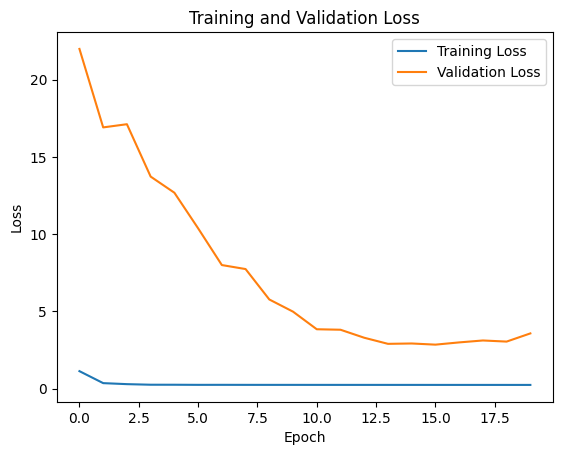

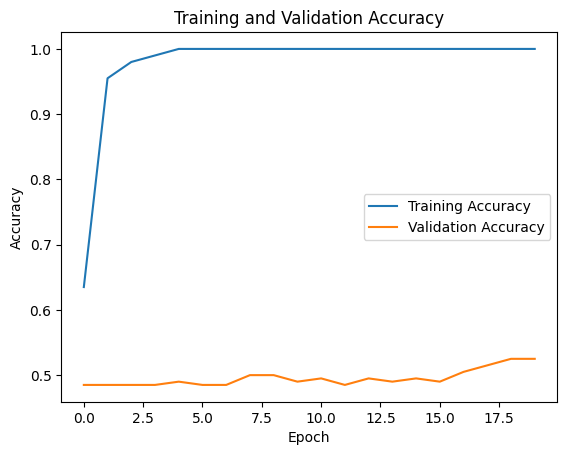

In [15]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [19]:
# Assuming `validation_ds` is another BatchDataset object containing validation data

# Evaluate the model on the validation dataset
validation_results = cnn_model.evaluate(validation_ds)

# Print validation loss and accuracy
print("Validation Loss:", validation_results[0])
print("Validation Accuracy:", validation_results[1])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.5072 - loss: 3.0774
Validation Loss: 2.941601037979126
Validation Accuracy: 0.5249999761581421
